# Preston's try

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import json
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

## Preparation

In [2]:
# load parameters
params_df = pd.read_csv("ML_param.csv")
# Just doing what the repo did
del params_df['coord_dec'] 
del params_df['coord_ra']
del params_df['id']
del params_df['parent']

In [3]:
# load classfication data
data_df = pd.read_csv("../classifications/lsst_run_one.csv")
data_df.head()
classify_df = data_df.loc[data_df['workflow_name'] == "Difference Imaging Classifier"]

image_class = np.zeros(classify_df.shape[0], dtype='int, object')
idx = 0
for _, row in classify_df.iterrows():
    s_data = json.loads(row.subject_data) #Subject Data
    s_data = s_data.get(list(s_data.keys())[0])
    # cut "/home/......./cutout" and ".png"
    image_num = s_data.get(list(s_data.keys())[1])[47:-4]
    # annotations
    a_data = json.loads(row.annotations)[0]
    classification = a_data['value']
    image_class[idx] = (int(image_num), classification)
    idx += 1

In [4]:
# add a new classification column, init with None
params_df = params_df.assign(Classification=Series(np.full(params_df.shape[0], None)))
for image in image_class:
    params_df.loc[image[0], "Classification"] = image[1]
# drop the rows with no classification
df = params_df[params_df["Classification"].notnull()]

In [5]:
# drop some columns
for col in df.columns:
    if df[col].isnull().all():
        del df[col]   
    elif df[col].dtype != 'object' and np.mean(df[col]) == np.inf:
        del df[col]
    elif "flag" in col: #Flags don't contribute to ML based on initial testing
        del df[col]
    
df = df.fillna(0)

In [6]:
df.head()

,image,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_6_0_flux,base_SdssShape_psf_xx,base_SdssShape_psf_xy,base_SdssCentroid_x,ip_diffim_PsfDipoleFlux_pos_fluxSigma,ip_diffim_PsfDipoleFlux_pos_flux,base_SdssShape_psf_yy,base_SdssShape_flux_xy_Cov,...,base_CircularApertureFlux_4_5_fluxSigma,ip_diffim_DipoleFit_separation,ip_diffim_DipoleFit_pos_fluxSigma,base_SdssShape_yy,base_CircularApertureFlux_9_0_flux,ip_diffim_PsfDipoleFlux_neg_centroid_x,base_CircularApertureFlux_12_0_flux,ip_diffim_DipoleFit_orientation,base_CircularApertureFlux_25_0_flux,Classification
0,0,9631.897876,714.726562,2.828649,-0.453969,225.833654,2515.781488,108909.800974,2.625221,-19.500092,...,176.950531,0.075128,675.617063,0.531181,661.367737,226.625613,418.723064,130.761641,1011.415786,Dipole
1,1,4203.040442,1035.672363,2.828649,-0.453969,1403.524349,0.000000,0.000000,2.625221,-24.382818,...,102.062622,0.000000,0.000000,2.142461,1011.458618,0.000000,1113.044229,0.000000,1657.226911,Possible Transient
2,2,1545.866122,-148.509018,2.828649,-0.453969,1516.439084,3339.446858,169312.388582,2.625221,0.000000,...,242.372284,0.066358,1329.376864,410.077555,159.960388,1516.969982,50.727865,-23.666280,194.104162,Subtraction Error
3,3,0.000000,32.771393,2.828649,-0.453969,65.176307,0.000000,0.000000,2.625221,-15.389731,...,145.347290,0.000000,0.000000,0.618887,209.429108,0.000000,-94.296964,0.000000,538.538759,Subtraction Error
4,4,10168.914930,718.301331,2.828649,-0.453969,834.630699,2950.619325,111744.638382,2.625221,-0.557023,...,203.650833,0.087032,859.469912,0.224596,1180.052612,834.469876,988.245036,85.948590,1932.348548,Subtraction Error


## Training, development, test (7:2:1)

In [24]:
# shuffle data
df.sample(frac=1)

# normalize
for col in df.columns:
    if df[col].dtype == "float64" or df[col].dtype == "int64":
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


# get rid of (super) low variance features
selector = VarianceThreshold(0.03)
training = selector.fit_transform(df.drop(columns=['Classification']))
labels = df['Classification']

length = training.shape[0]
train_split = int(length * 0.7)
dev_split = int(length * 0.9)

train_X = training[0 : train_split]
dev_X = training[train_split : dev_split]
test_X = training[dev_split:]
train_y = labels[0 : train_split]
dev_y = labels[train_split : dev_split]
test_y = labels[dev_split:]

## Classification

### SVM

In [25]:
clf = svm.SVC(kernel='linear', C=1, verbose=True)

### Hyperparams Tuning

450 0.16690647482014387
15 0.16666666666666663
400 0.1482014388489209
400 0.14141414141414144


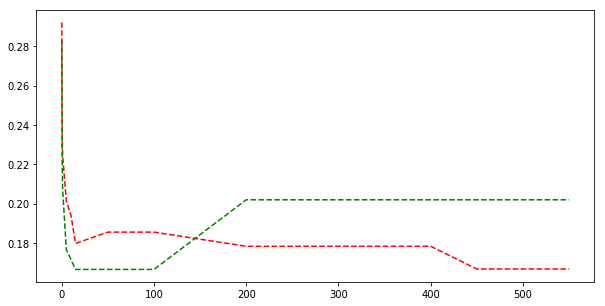

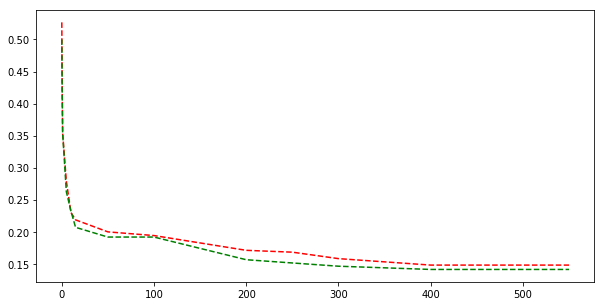

In [26]:
C = [0.1, 0.5, 1, 5, 10, 15, 50, 100, 200, 250, 300, 400, 450, 480, 500, 550]
kernels = ['linear', 'polynomial', 'rbf']

train_errs = np.zeros(len(C))
dev_errs = np.zeros(len(C))
for i, c in enumerate(C):
    clf = svm.SVC(kernel=kernels[0], C=c)
    clf.fit(train_X, train_y)
    train_err = 1 - clf.score(train_X, train_y)
    dev_err = 1 - clf.score(dev_X, dev_y)
    train_errs[i] = train_err
    dev_errs[i] = dev_err
    
    
print(C[np.argmin(train_errs)], np.min(train_errs))
print(C[np.argmin(dev_errs)], np.min(dev_errs))

fig, ax = plt.subplots(nrows=1, ncols=1)    
fig.set_size_inches(10, 5)
ax.plot(C, train_errs, 'r--')
ax.plot(C, dev_errs, 'g--')


train_errs = np.zeros(len(C))
dev_errs = np.zeros(len(C))
for i, c in enumerate(C):
    clf = svm.SVC(kernel=kernels[2], C=c)
    clf.fit(train_X, train_y)
    train_err = 1 - clf.score(train_X, train_y)
    dev_err = 1 - clf.score(dev_X, dev_y)
    train_errs[i] = train_err
    dev_errs[i] = dev_err
    

print(C[np.argmin(train_errs)], np.min(train_errs))
print(C[np.argmin(dev_errs)], np.min(dev_errs))
    
fig, ax = plt.subplots(nrows=1, ncols=1)    
fig.set_size_inches(10, 5)
ax.plot(C, train_errs, 'r--')
ax.plot(C, dev_errs, 'g--')



### SVM with rbf kernel with L1 penalty 400 seems great, testing:

In [27]:
clf = svm.SVC(kernel='rbf', C=250)
print(clf.fit(train_X, train_y))
print(clf.score(test_X, test_y))

SVC(C=250, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8
